### Fine-tuning mt5 for cleaning italian ocr text

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm 
import evaluate
import numpy as np
from datasets import Dataset
from datasets import load_from_disk
from datasets import concatenate_datasets
import seaborn as sns
import json
import random


2025-09-02 15:58:20.061588: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load datasets

In [3]:
train = load_from_disk("../datasets/t5-datasets/train")

# We reserve a 5% of the training set for evaluation
train = train.train_test_split(test_size=0.05)

In [4]:
train_dataset = train['train']
eval_dataset = train['test']

#### Load mt5-small and its tokenizer

In [5]:
model = AutoModelForSeq2SeqLM.from_pretrained("../../mt5-base")
tokenizer = AutoTokenizer.from_pretrained("../../mt5-base")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/gjergj/.local/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


#### Data Preparation

Before proceeding let's first check the length of the encoded samples.

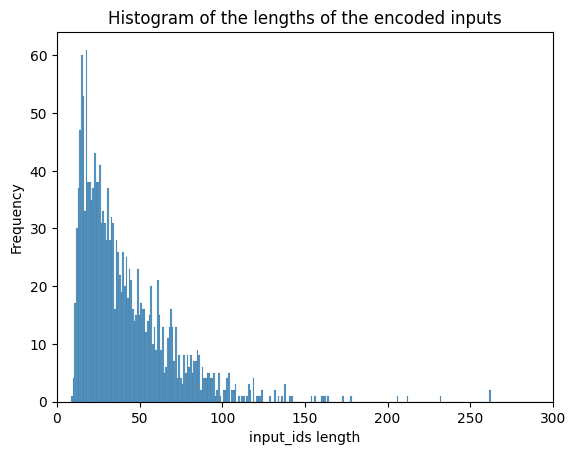

In [6]:
encoded_inputs_length = [] # store the length of the encoded samples

for sample in train_dataset:
    input_ids = tokenizer.encode(sample['ocr'], return_tensors='pt')
    encoded_inputs_length.append(len(input_ids[0]))


encoded_inputs_length.sort(reverse=True)

sns.histplot(encoded_inputs_length, bins=10, discrete=True)

plt.xlim(0, 300)
plt.xlabel('input_ids length')
plt.ylabel('Frequency')
plt.title('Histogram of the lengths of the encoded inputs')

plt.show()

In [7]:
print(model.config.max_length)

20


As showed above, the predefined input length of mt5 is 20 tokens. But as we can see from the histogram above, a significant number of tokenized samples are longer than just 20 tokens. Therefore, in order to not lose too much data, instead of just truncating the samples, we create chunks of 20 tokens. As an example, the two strings:

ocr:  
   \ 

iiiastri 
Si  avviticchiò  colle  braccia,  stretto  stretto,  al  collo  
della  sua  piamata  cavalcatura.

clean:  
Si avviticchiò colle braccia, stretto stretto, al collo della sua piumata cavalcatura.

become:
```
['▁', '\\', '▁iii', 'a', 'stri', '▁Si', '▁avvi', 'tic', 'chi', 'ò', '▁colle', '▁', 'braccia', ',', '▁stret', 'to', '▁stret', 'to', ',', '</s>']
['▁Si', '▁avvi', 'tic', 'chi', 'ò', '▁colle', '▁', 'braccia', ',', '▁stret', 'to', '▁stret', 'to', ',', '▁al', '▁collo', '▁', 'della', '▁sua', '</s>']

['▁al', '▁collo', '▁', 'della', '▁sua', '▁pi', 'amata', '▁caval', 'c', 'atura', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['▁piu', 'mata', '▁caval', 'c', 'atura', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
```

NOTE: To avoid having examples that are too short (in some extreme cases composed by just the EOS token), we truncate the sentence when 
the residual length of the sample is less than 5 tokens.


**Data Augmentation**  
Before proceeding in splitting the samples in chunks of 20 tokens, we consider the possibility of applying some data augumentation. To do so, we define a dictionary with the most common mistakes (for example `i → 1 or l`, `m → rn`, `n → ri` and so on). Then, each time we encounter one of the the keys of the dictionary, we manually make the substitution with a probablity $p$. For simplicity we select samples that are no longer than 18 tokens, which correspond to roughly 5% of the training dataset. 

In [7]:
# First we select some candidate samples, to which apply might apply some augmentation

candidates = [] 
for sample in train_dataset:
    input_ids = tokenizer.encode(sample['ocr'], return_tensors='pt')[0]
    if len(input_ids) < 19:
        candidates.append(sample)


In [8]:
common_errors = {'i': ['1', 'l'], 'o': ['0'], 'm': ['rn'], 'n': ['ri'], 'l':['1'], 'c': ['e'], 
                 'a': ['o'], 'r':['v'], 't': ['f'], 's':['5'], 'z': ['2'], 'b': ['h', 'l'], 
                 'rn': ['m'], 'ri': ['n'], 'cl': ['d'], 'li': ['h'], 'vv': ['w'], 'lu': ['U'], 
                 'è': ['e', 'é'], 'ò': ['o', 'ó'], 'à': ['a', 'á']}

def augment_data(samples, p):

    ''' 
    - samples to which apply data augmentation
    - p: probability that a character or a bigram is changes with one of the common erros
         NOTE: we keep this probablity very low (around 10 %) since the ocr samples 
               present already a lot of noise   
    '''
    modified_samples = []

    keys = common_errors.keys()
    for sample in candidates:
        # check characters
        modified = False
        ocr_sample = sample['ocr']
        for i in range(len(ocr_sample)):
            c = ocr_sample[i]
            if c in keys:
                rv = random.random()
                if p >= rv:
                    ocr_sample = ocr_sample[:i] + random.choice(common_errors[c]) + ocr_sample[i+1:]
                    modified = True

        # check bigrams
        for i in range(0, len(ocr_sample), 2):
            bigram = ocr_sample[i: i+2]

            if bigram in keys:
                rv = random.random()
                if p >= rv:
                    ocr_sample = ocr_sample[:i] + random.choice(common_errors[bigram]) + ocr_sample[i+2:]
                    modified = True

        # if the sample was modified, we store it 
        if modified:
            new_sample = {}
            new_sample['ocr'] = ocr_sample
            new_sample['clean'] = sample['clean']
            modified_samples.append(new_sample)
    
    return modified_samples


In [9]:
modified_samples = augment_data(candidates, p=0.10)

print(f"Total modified samples: {len(modified_samples)}\n")

# Let's print the first 10 samples
for i in range(10):
    print(modified_samples[i])

Total modified samples: 307

{'ocr': ' \n—  In  che  mondo  siamo  condannatl  a  vivere', 'clean': '— In che mondo siamo condannati a vivere?'}
{'ocr': '  Ohe  5ia  la  rnedesirna  malatfia? \n\n\n—  Ho  poura  di  sì.', 'clean': 'Che sia la medesima malattia?— Ho paura di sì.'}
{'ocr': " \nL'ultlmo  che  restò  nella  refe  fu  Pinocchi0.", 'clean': 'L’ultimo che restò nella rete fu Pinocchio.'}
{'ocr': '  dnnque  sei  tu  che  ml  porti  via  le  ga1line?', 'clean': 'dunque sei tu che mi porti via le galline?'}
{'ocr': '  — \nFigurotevi  il  povero  Arlecchino!', 'clean': '—\nFiguratevi il povero Arlecchino!'}
{'ocr': ' \n\n—  E  1o  invece  vogl1o  andave  avanti.', 'clean': '— E io invece voglio andare avanti.'}
{'ocr': ' \n—  E  io  r  ho  provato  !  —  disse  Pin0cchio.', 'clean': '— E io l’ho provato!— disse Pinocchio.'}
{'ocr': '  ! \n—  P1età,  signor  Commendatore', 'clean': '— Pietà, signor Commendatore!...'}
{'ocr': ' \n—  Sapete  che  cosa  farò  ?  —  disse  Pinocchi0.'

In [10]:
# convert the new samples in a hugging face Dataset and concatenate it with 
# the original train set
augmented_samples = Dataset.from_list(modified_samples)
train_dataset = concatenate_datasets([train_dataset, augmented_samples])
print(train_dataset)

Dataset({
    features: ['ocr', 'clean'],
    num_rows: 2020
})


We can now proceed and split the samples in chunks of 20 tokens. In what follwos we define two functions.   
1. `create_chunks`: that takes care of creating the chunks of length 19
2. `pad_functions`: that takes care of adding the **EOS** (`</s>`) token and padding samples that are shorter than 20 tokens

In [11]:
def pad_function(ocr_chunk, clean_chunk):
    ''' 
    Function that takes as input the ocr_chunk and clean_chunk, 
    adds the EOS token (if needed) and pads the samples (if needed) 
    to have the correct length
    '''
    if len(ocr_chunk) < 20:
        # if the length of the tensor is less than 20, we pad it
        while len(ocr_chunk) < 20:
            ocr_chunk = torch.cat((ocr_chunk, torch.tensor([0]))) 
    else:
        # keep only the first 20 tokens
        ocr_chunk = ocr_chunk[:20]
        if ocr_chunk[-1].item() != 1:       # if needed, add </s> (EOS) token
            ocr_chunk[-1] = 1

    # Now we do the same for the clean chunk
    if len(clean_chunk) < 20:
        while len(clean_chunk) < 20:
            clean_chunk = torch.cat((clean_chunk, torch.tensor([0]))) 
    else:
        # keep only the first 20 tokens
        clean_chunk = clean_chunk[:20]
        if clean_chunk[-1].item() != 1:
            clean_chunk[-1] = 1

    return (ocr_chunk, clean_chunk)
        

In [12]:
def create_chunks(ocr_tokens, clean_tokens):
    ''' 
    - ocr_tokens: token ids of the ocr sample
    - clean_tokens: token ids of the clean sample
    
    Function that creates chunks of 20 tokens
    '''
    pairs = []
    max_len = max(len(ocr_tokens), len(clean_tokens))
    for i in range(0, max_len, 19): # 19 beacuse we need to reserve one token for the
                                    # end of sentence (</s>) token
        
        if i == 0:
            if min(len(ocr_tokens), len(clean_tokens)) < 25:         
                # when one of the two samples is shorter than 20 tokens, 
                # we make sure that the EOS token is present in both of them 
                # and pad (if needed) the samples to have the correct length
                pair = pad_function(ocr_tokens, clean_tokens)
                pairs.append(pair)

                return pairs

            else:
                # otherwise, we take the next 19 tokens and add the EOS token
                ocr_chunk = ocr_tokens[:19]
                clean_chunk = clean_tokens[:19]

                # Add EOS token
                ocr_chunk = torch.cat((ocr_chunk, torch.tensor([1])))
                clean_chunk = torch.cat((clean_chunk, torch.tensor([1])))

        else:
            
            if min(len(ocr_tokens[i:]), len(clean_tokens[i:])) < 25:
                ocr_chunk = ocr_tokens[i:]
                clean_chunk = clean_tokens[i:]

                pair = pad_function(ocr_chunk, clean_chunk)
                pairs.append(pair)

                return pairs
            
            else:
                ocr_chunk = ocr_tokens[i:i+19]
                clean_chunk = clean_tokens[i:i+19]

                # Add EOS token
                ocr_chunk = torch.cat((ocr_chunk, torch.tensor([1])))
                clean_chunk = torch.cat((clean_chunk, torch.tensor([1])))


        pairs.append((ocr_chunk, clean_chunk))
        
    return pairs
    

Now we write some auxiliary functions that compute the token ids for each sample in the dataset. and call the `create_chunk` function to produce chunks of 20 tokens.

In [13]:
def encode_sample(sample, tokenizer):
    ''' 
    Function that tokenizes each sample, and passes them to 'create_chunks' function, 
    that creates chunks of 20 tokens
    
    - sample: ['ocr', 'clean']
    '''
    ocr = sample['ocr']
    clean = sample['clean']

    if ocr is None or clean is None:
        return None 
    
    input_token_ids = tokenizer.encode(ocr, return_tensors='pt')[0]
    target_token_ids = tokenizer.encode(clean, return_tensors='pt')[0]

    chunks = create_chunks(input_token_ids, target_token_ids)

    return chunks

In [14]:
def tokenize_dataset(dataset, tokenizer):
    tokenized_dataset = {}
    tokenized_dataset['ocr'] = []
    tokenized_dataset['clean'] = []

    for sample in dataset:
        chunks = encode_sample(sample, tokenizer)
        for pair in chunks:
            if pair[0] == None or pair[1] == None:
                continue

            tokenized_dataset['ocr'].append(pair[0])
            tokenized_dataset['clean'].append(pair[1])

    return tokenized_dataset


In [15]:
tokenized_train_data = tokenize_dataset(train_dataset, tokenizer)
tokenized_val_data = tokenize_dataset(eval_dataset, tokenizer)

In [16]:
# Sanity check, verify that the produced chuncks have all size 20
dataset_size = len(tokenized_train_data['ocr'])
for i in range(dataset_size):
    if tokenized_train_data['ocr'][i].shape != torch.Size([20]) or tokenized_train_data['clean'][i].shape != torch.Size([20]):
        print(i)
        print(tokenized_train_data['ocr'][i])
        print(tokenized_train_data['clean'][i])
        print("ERROR: some samples have not size 20")
        break
print("All fine")

All fine


Let's see what a sample looks like.

In [ ]:
# Let's now take a random sample and retrieve the original text
ocr = tokenized_train_data['ocr'][858]
clean = tokenized_train_data['clean'][858]

print(f'ocr_input_ids: \n {ocr}\nclean_input_ids:\n{clean}\n')

# let's decode the samples
ocr_text = tokenizer.decode(ocr, skip_special_tokens=True)
clean_text = tokenizer.decode(clean, skip_special_tokens=True)

print(f'ocr_text: {ocr_text}\nclean_text: {clean_text}')

ocr_input_ids: 
 tensor([  259,   280,  3430,   444,  4527,  1133,   907,   259,   262,  2736,
         2087,   692, 44250,   377,   259,  3501, 30864,   301,  1726,     1])
clean_input_ids:tensor([ 4879,  4527,  1133,   907,   259,   262,  2736,  2087,   692,   360,
        57402,   259,  3501, 30864, 93560,   268, 68596,   350,   416,     1])

ocr_text: l^on starò qui a farvi menzogna delle grandi difi
clean_text: Non starò qui a farvi menzogne delle grandi difficoltà da me


### Dataset Preparation

In [2]:
class CustomDataset(data.Dataset):

    def __init__(self, dataset):
        super().__init__()

        ''' 
        - dataset: Python dictionary of the form:
                   {'ocr': [list of ocr samples], 'clean': [list of the corresponding clean samples]}
        '''
        
        self.data = []
        self.num_samples = len(dataset['ocr'])
        self.ocr_samples = dataset['ocr']
        self.clean_samples = dataset['clean']

        # training data will be a list of dictionaries
        # each dictionary contains two keys: 'ocr' and 'clean' 

        for i in range(self.num_samples):
            ocr_sample = self.ocr_samples[i]
            clean_sample = self.clean_samples[i]

            sample = {'ocr': ocr_sample, 'clean': clean_sample}
            self.data.append(sample)

    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, index):
        return self.data[index]
    

In [ ]:
training_samples = CustomDataset(dataset=tokenized_train_data)
val_samples = CustomDataset(dataset=tokenized_val_data)  

### Training 

In [27]:
# training hyperparameters
n_epochs = 2
train_batch_size = 8
eval_batch_size = 4
print_freq = 25
lr = 5e-4
len_dataset = len(training_samples)
n_batches = int(np.ceil(len_dataset / train_batch_size))
total_steps = n_epochs * n_batches 
n_warmup_steps = int(total_steps * 0.01)

In [28]:
print(f'Total Steps: {total_steps}')
print(f'Warmup Steps: {n_warmup_steps}')

Total Steps: 1052
Warmup Steps: 10


In [29]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
# We define a scheduler that will take care of adapting the learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, n_warmup_steps, total_steps)

#### The Trainer class

In [36]:
class Trainer():

    def __init__(self, model, optimizer, scheduler, num_epochs):
        self.model = model 
        self.optimizer = optimizer
        self.scheduler = scheduler 
        self.num_epochs = num_epochs

    def train(self, train_dataset, val_dataset):

        train_loss = []
        val_loss = []
        for epoch_idx in range(n_epochs):   

            for batch_idx, sample in tqdm(enumerate(train_dataset), total=n_batches):

                input_batch = sample['ocr']
                label_batch = sample['clean']

                # zero the gradients
                optimizer.zero_grad()

                # forward pass
                model_out = model.forward(
                    input_ids = input_batch, 
                    labels = label_batch    # not strictly necessarily, but if we do it,
                                            # it computes the loss for us
                )

                loss = model_out.loss
                train_loss.append(loss.item())

                # compute the gradients
                loss.backward()

                # update the weights
                optimizer.step()

                # The scheduler adaptes the leraning rate
                scheduler.step()

                if (batch_idx + 1) % print_freq == 0:
                    #average loss for the last 'print_freq' batches
                    avg_loss = np.mean(train_loss[-print_freq:])
                    eval_loss = self.eval_model(val_dataset)
                    val_loss.append(eval_loss)
                    print('Epoch: {} | Step: {} | Avg. train loss: {:.3f} | Avg. val loss: {:.3f} | lr: {}'.format(
                        epoch_idx+1, batch_idx+1, avg_loss, eval_loss, scheduler.get_last_lr()[0]))


            model.save_pretrained(f"../model/checkpoints/mt5-base-{epoch_idx}")
            tokenizer.save_pretrained(f"../model/checkpoints/mt5-base-{epoch_idx}")            

        return {
            "train_loss": train_loss, 
            "val_loss": val_loss
        }
    

    def eval_model(self, validation_dataset):
        eval_losses = []

        with torch.no_grad():
            for sample in validation_dataset:
                input_batch = sample['ocr']
                label_batch = sample['clean']

                # forward pass
                model_out = model.forward(input_ids=input_batch, 
                                        labels=label_batch)     # As before we pass also the labels, so it 
                                                                # computes for us also the loss
            
                eval_losses.append(model_out.loss.item())

        
        return np.mean(eval_losses)

The last thing to do, before training, is to load the data using the `DataLoader` module.

In [33]:
training_dataset = DataLoader(training_samples, batch_size=train_batch_size, shuffle=True)
validation_dataset = DataLoader(val_samples, batch_size=eval_batch_size)

In [37]:
trainer = Trainer(model=model,
                  optimizer=optimizer, 
                  num_epochs=n_epochs, 
                  scheduler=scheduler)

In [38]:
history = trainer.train(training_dataset, validation_dataset)

  0%|          | 0/526 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch: 1 | Step: 25 | Avg. train loss: 9.394 | Avg. val loss: 4.669 | lr: 0.0004928023032629558
Epoch: 1 | Step: 50 | Avg. train loss: 3.913 | Avg. val loss: 2.242 | lr: 0.00048080614203454896
Epoch: 1 | Step: 75 | Avg. train loss: 1.725 | Avg. val loss: 1.448 | lr: 0.0004688099808061421
Epoch: 1 | Step: 100 | Avg. train loss: 1.327 | Avg. val loss: 1.327 | lr: 0.00045681381957773514
Epoch: 1 | Step: 125 | Avg. train loss: 1.161 | Avg. val loss: 1.240 | lr: 0.00044481765834932825
Epoch: 1 | Step: 150 | Avg. train loss: 1.154 | Avg. val loss: 1.153 | lr: 0.0004328214971209213
Epoch: 1 | Step: 175 | Avg. train loss: 1.064 | Avg. val loss: 1.089 | lr: 0.00042082533589251443
Epoch: 1 | Step: 200 | Avg. train loss: 0.957 | Avg. val loss: 1.037 | lr: 0.00040882917466410754
Epoch: 1 | Step: 225 | Avg. train loss: 0.950 | Avg. val loss: 0.981 | lr: 0.0003968330134357006
Epoch: 1 | Step: 250 | Avg. train loss: 1.054 | Avg. val loss: 0.978 | lr: 0.0003848368522072937
Epoch: 1 | Step: 275 | Avg. 

  0%|          | 0/526 [00:00<?, ?it/s]

Epoch: 2 | Step: 25 | Avg. train loss: 0.484 | Avg. val loss: 0.800 | lr: 0.00024040307101727448
Epoch: 2 | Step: 50 | Avg. train loss: 0.576 | Avg. val loss: 0.807 | lr: 0.00022840690978886757
Epoch: 2 | Step: 75 | Avg. train loss: 0.573 | Avg. val loss: 0.880 | lr: 0.00021641074856046066
Epoch: 2 | Step: 100 | Avg. train loss: 0.629 | Avg. val loss: 0.885 | lr: 0.00020441458733205377
Epoch: 2 | Step: 125 | Avg. train loss: 0.607 | Avg. val loss: 0.831 | lr: 0.00019241842610364686
Epoch: 2 | Step: 150 | Avg. train loss: 0.524 | Avg. val loss: 0.909 | lr: 0.00018042226487523995
Epoch: 2 | Step: 175 | Avg. train loss: 0.571 | Avg. val loss: 0.848 | lr: 0.00016842610364683304
Epoch: 2 | Step: 200 | Avg. train loss: 0.564 | Avg. val loss: 0.853 | lr: 0.00015642994241842612
Epoch: 2 | Step: 225 | Avg. train loss: 0.531 | Avg. val loss: 0.836 | lr: 0.0001444337811900192
Epoch: 2 | Step: 250 | Avg. train loss: 0.576 | Avg. val loss: 0.887 | lr: 0.0001324376199616123
Epoch: 2 | Step: 275 | Av

In [39]:
# Save the model and tokenizer
model.save_pretrained("../model/fine-tuned-models/mt5-base-run2")
tokenizer.save_pretrained("../model/fine-tuned-models/mt5-base-run2")

('../model/fine-tuned-models/mt5-base-run2/tokenizer_config.json',
 '../model/fine-tuned-models/mt5-base-run2/special_tokens_map.json',
 '../model/fine-tuned-models/mt5-base-run2/spiece.model',
 '../model/fine-tuned-models/mt5-base-run2/added_tokens.json',
 '../model/fine-tuned-models/mt5-base-run2/tokenizer.json')

#### Plots

In [40]:
def plot(data, label):
    plt.plot(data, label=label)
    plt.legend()
    plt.show()

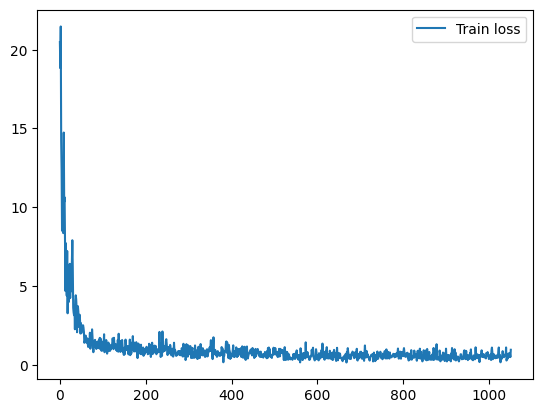

In [41]:
plot(history['train_loss'], label='Train loss')

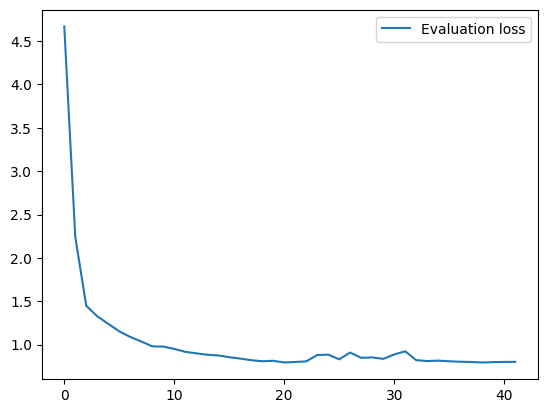

In [42]:
plot(history['val_loss'], label='Evaluation loss')

#### Testing and Inference

In [4]:
# Load the fine-tuned model
mt5_finetuned = AutoModelForSeq2SeqLM.from_pretrained("../model/checkpoints/mt5-base-0")
mt5_tokenizer = AutoTokenizer.from_pretrained("../model/checkpoints/mt5-base-0")

In [ ]:
mt5_finetuned.eval()

In [6]:
# Load the test dataset
test = load_from_disk("../datasets/t5-datasets/test")

In [7]:
ocr_sample = test[0]['ocr']
clean_sample = test[0]['clean']

In [8]:
print(f'ocr_sample:\n{ocr_sample}\n')
print(f'clean_sample:\n{clean_sample}')

ocr_sample:
I. 
Como  andò  che  Maestro  Ciliegia,  Megnamc 
trovò  un  pezzo  di  legno  che  piangeva  e  rideva  come  un  bambino.

clean_sample:
I.Come andò che Maestro Ciliegia, falegname
trovò un pezzo di legno che piangeva e rideva come un bambino.


In [ ]:
input_ids = mt5_tokenizer.encode(ocr_sample, return_tensors='pt')[0]
print(input_ids)
print(len(input_ids))
input_ids = input_ids[:20]
tokens = mt5_tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)
input_ids = input_ids.unsqueeze(0)

print(input_ids)

output_tokens = mt5_finetuned.generate(input_ids, num_beams=8, num_return_sequences=1)
prediction = mt5_tokenizer.decode(output_tokens[0], skip_special_tokens=True)
print(prediction)

tensor([   336,    260,   7872,    305,   1133,    734,    259, 106984,    371,
          2306, 122131,    261,  17622,  18075,    297,  38323,   1133,    335,
           421,  46669,    301,   4034,    505,    734,  40624, 180977,    259,
           265,  41585,    834,   1532,    335,  61230,    268,    260,      1])
36
['▁I', '.', '▁Como', '▁and', 'ò', '▁che', '▁', 'Maestro', '▁C', 'ili', 'egia', ',', '▁Meg', 'nam', 'c', '▁trov', 'ò', '▁un', '▁p', 'ezzo']
tensor([[   336,    260,   7872,    305,   1133,    734,    259, 106984,    371,
           2306, 122131,    261,  17622,  18075,    297,  38323,   1133,    335,
            421,  46669]])
I.Como andò che Maestro Ciliegia, Megnamc trovò un pezzo


#### Data preparation for inference

As before, we'll need to split the data in chunks of 20 tokens, however, here we can't allow the mismatches that we had before. Therefore, in order to match the ocr samples with the clean ones, we use the `sequence-alignment` algorithm, usually adopted in bioinformatics for aligning sequences of genes. The idea is the following.  
Say we want to align the follwing strings *stop* and *tops*. A possibility is:  
`stop-`  
`-tops`  
As it can be seen there from the simple example considered above, there are two aspects that we need to clarify:
1. First, it might not be possible at all to match a character with another one (this is clear when the length of the two strings is different), therefore we'll need to define a parameter $\delta > 0$, that represents the **gap penalty**.
2. Second, we need to define a mismatch cost $\alpha > 0$, i.e. a price that we "pay" whenever we align two different characters.   

Now, with that said, we have three possible cases that can occur. Consider an optimal alignment *M* of two string *X* and *Y*, then at least one of the follwing is true:
1. $(m, n) \in M$; 
2. the $m^{th}$ position of X is not matched;
3. the $n^{th}$ position of Y in not matched;

With these observations we can define the follwoing recursion that computes the mimimum cost for aligning two sequences:  
$$OPT(i, j) = min[\alpha_{x_iy_j} + OPT(i-1, j-1), \delta + OPT(i-1, j), \delta + OPT(i, j-1)]$$

Using the recursion above, we can implement an algorithm that computes the *minimum-cost* for aligning two sequences. However, this does not output the optimal alignment, but we'll need to retrieve it.  
To birefly give an intuition, consider the picture above, where the algorithm tries to align *name* with *mean*.  

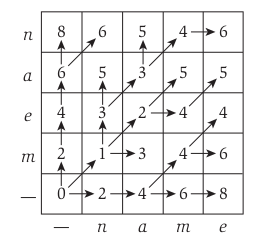  

If we look at the matrix as a graph, it can be shown that the value of the optimal alignment is the length if the shortest path from the node $(0, 0)$ to $(m, n)$. Following the arrows backward from from node (4, 4), we can trace back to reconstruct the alignment.  
So, to reconstruct:
1. Trace back through the filled table, startin at M[m, n]
2. If M[i, j] was filled using:
    1. case 1, go to $(i-1, j-1)$
    2. case 2, go to $(i-1, j)$
    3. case 3, go to $(i, j-1)$
3. If either i = 0 or j = 0, match the remaining substring with *gaps*.  

NOTE: Here we will apply the algorithm to align tokens instead of of characters.

In [7]:
def sequence_alignment(A, B, delta, alpha):
    ''' 
    - A: token ids of the ocr sample
    - B: token ids of the clean sample 
    - delta: penalty gap
    - alpha: penalty mismatch
    '''
    m = len(A)
    n = len(B)

    # As gap token we use: @ → 1250 (beacuse it never occurs in the dataset, and it is encoded with just one value)
    gap_token = 1250


    # initaliaze the matrix
    M = np.zeros((m+1, n+1), dtype=int)

    # for purposes of initialization, we fill the first row and the first column 
    # with the cost that we would pay to align an i-letter word with a 0-letter
    # word. And the only way to do so is by using gaps
    for i in range(m+1):
        M[i, 0] = i * delta 

    for j in range(n+1):
        M[0, j] = j * delta 

    # Now we compute the cost matrix
    for i in range(1, m+1):
        for j in range(1, n+1):
            cost = 0 if A[i-1] == B[j-1] else alpha

            M[i, j] = min(cost + M[i-1, j-1], delta + M[i-1, j], delta + M[i, j-1])



    # In the following we backtrack from the cost matrix to 
    # reconstuct the solution
    l = n + m
    i = m
    j = n

    ocr_pos = l
    clean_pos = l 

    ocr = np.zeros(l+1, dtype=int)
    clean = np.zeros(l+1, dtype=int)

    while not (i == 0 or j == 0):
        if A[i-1] == B[j-1]:    # case where the two tokens match
            ocr[ocr_pos] = A[i-1]
            clean[clean_pos] = B[j-1]
            ocr_pos -= 1
            clean_pos -= 1 
            i -= 1 
            j -= 1 

        elif (M[i-1][j-1] + alpha) == M[i][j]:  # case where we have a mismatch
            ocr[ocr_pos] = A[i-1]
            clean[clean_pos] = B[j-1]
            ocr_pos -= 1 
            clean_pos -= 1
            i -= 1
            j -= 1 

        elif (M[i-1][j] + delta) == M[i][j]:    # case where we use a gap
            ocr[ocr_pos] = A[i-1]
            clean[clean_pos] = gap_token
            ocr_pos -= 1
            clean_pos -= 1 
            i -= 1

        elif (M[i][j-1] + delta) == M[i][j]:    # case where we use a gap
            ocr[ocr_pos] = gap_token
            clean[clean_pos] = B[j-1]
            ocr_pos -= 1
            clean_pos -= 1
            j -= 1 
    
   
   # If needed, fill the remaining positions with gaps
    while ocr_pos > 0:
        if i > 0:
            i -= 1
            ocr[ocr_pos] = A[i]
            ocr_pos -= 1
        else:
            ocr[ocr_pos] = gap_token
            ocr_pos -= 1

    while clean_pos > 0:
        if j > 0:
            j -= 1
            clean[clean_pos] = B[j]
            clean_pos -= 1

        else:
            clean[clean_pos] = gap_token
            clean_pos -= 1

    # since we have assumed that the final answer is long m + n, 
    # we remove the gaps from the initial positions. 
    # The variable 'id' will store the starting index from where 
    # to retireve the aligned sequences
    id = 1
    i = l

    while i > 0:
        if ocr[i] == gap_token and clean[i] == gap_token:   # if both the positions are filled with a gap, skip them
            id = i + 1
            break 

        i -= 1

    # Now ì, we are finally ready to retrieve the aligned sequences
    i = id
    x_seq = []

    while i <= l:
        x_seq.append(ocr[i])
        i += 1


    i = id 
    y_seq = []

    while i <= l:
        y_seq.append(clean[i])
        i += 1 
   

    return torch.tensor(x_seq), torch.tensor(y_seq)



In [8]:
def pad(ocr_chunk, clean_chunk):
    if ocr_chunk[-1].item() != 1:       # if needed, add </s> (EOS) token
        ocr_chunk = torch.cat((ocr_chunk, torch.tensor([1])))

    if len(ocr_chunk) < 20:             # if needed, pad to the desired length
        while len(ocr_chunk) < 20:
            ocr_chunk = torch.cat((ocr_chunk, torch.tensor([0])))   

    # we do the same for the clean sample
    if clean_chunk[-1].item() != 1:
        clean_chunk = torch.cat((clean_chunk,  torch.tensor([1])))

    if len(clean_chunk) < 20:
        while len(clean_chunk) < 20:
            clean_chunk = torch.cat((clean_chunk, torch.tensor([0])))

    return (ocr_chunk, clean_chunk)

In [9]:
def chunk_dataset(dataset, tokenizer):
    ''' 
    - dataset: test dataset
    - tokenizer: mt5 tokenizer
    '''
    chunked_dataset = {}
    chunked_dataset['ocr'] = []
    chunked_dataset['clean'] = []

    tokenized_chunked_dataset = {}
    tokenized_chunked_dataset['ocr'] = []
    tokenized_chunked_dataset['clean'] = []

    gap_token = 1250    # @ → we will remove this from the samples

    # It can happen that some chunks are empty, or are composed
    # by just one 'special' symbol (e.g. !, ?, .). We remove such 
    # extreme cases
    elems = ['', ',', '.', '?', '!']   


    for sample in dataset:
        ocr_sample = sample['ocr']
        clean_sample = sample['clean']

        # compute the token ids
        encoded_ocr = tokenizer.encode(ocr_sample, return_tensors='pt')[0]
        encoded_clean = tokenizer.encode(clean_sample, return_tensors='pt')[0]

        # align the token ids
        ocr_seq, clean_seq = sequence_alignment(encoded_ocr, encoded_clean, delta=2, alpha=1)
        
        # Now we can proceede and produce chunks of 20 tokens
        for i in range(0, len(ocr_seq), 19):

            ocr_chunk = ocr_seq[i: i+19]
            clean_chunk = clean_seq[i: i+19]

            # remove the gap token
            mask = ocr_chunk != gap_token
            ocr_chunk = ocr_chunk[mask]

            mask = clean_chunk != gap_token
            clean_chunk = clean_chunk[mask]

            decoded_ocr = tokenizer.decode(ocr_chunk, skip_special_tokens=True)
            decoded_clean = tokenizer.decode(clean_chunk, skip_special_tokens=True)

            # remove samples that are empty or composed by just 
            # one "special" character 
            if decoded_ocr in elems or decoded_clean in elems:
                continue

            # make sure that the last elem is the </s> token and
            # pad to the desired length
            ocr_chunk, clean_chunk = pad(ocr_chunk, clean_chunk)

            chunked_dataset['ocr'].append(decoded_ocr)
            chunked_dataset['clean'].append(decoded_clean)

            tokenized_chunked_dataset['ocr'].append(ocr_chunk)
            tokenized_chunked_dataset['clean'].append(clean_chunk)

    return chunked_dataset, tokenized_chunked_dataset

            

In [13]:
chunked_test_data, tokenized_chunked_test_data = chunk_dataset(test, mt5_tokenizer)

In [14]:
# Let's print the first 10 samples and look at the result
i = 0
for ocr, clean in zip(chunked_test_data['ocr'], chunked_test_data['clean']):
    print(f'ocr: {ocr},  clean: {clean}')
    i += 1
    if i == 10:
        break

ocr: I. Como andò che Maestro Ciliegia, Megnamc trovò un p,  clean: I.Come andò che Maestro Ciliegia, falegname trovò un p
ocr: ezzo di legno che piangeva e rideva come un bambino.,  clean: ezzo di legno che piangeva e rideva come un bambino.
ocr: — C'era una volta.... — Un re!,  clean: — C’era una volta.... — Un re!
ocr: -diranno subito i miei piccoli lettori.,  clean: — diranno subito i miei piccoli lettori.
ocr: — Ko, ragazzi, avete sbagliato.,  clean: — No, ragazzi, avete sbagliato.
ocr: C'era una volta un pezzo di legno.,  clean: C’era una volta un pezzo di legno.
ocr: Kon era un legno di lusso, ma un semplice pezzo da catasta,,  clean: Non era un legno di lusso, ma un semplice pezzo da catasta,
ocr: di quelli che d' inverno si met- tono nelle stufe e,  clean: di quelli che d’inverno si mettono nelle stufe e
ocr: nei caminetti per accendere il fuoco e per riscaldare le stanze,  clean: nei caminetti per accendere il fuoco e per riscaldare le stanze
ocr: Non so come andasse, ma il f

In [15]:
# Sanity check, verify that the produced chunks have all size 20
dataset_size = len(tokenized_chunked_test_data['ocr'])
for i in range(dataset_size):
    if tokenized_chunked_test_data['ocr'][i].shape != torch.Size([20]) or tokenized_chunked_test_data['clean'][i].shape != torch.Size([20]):
        print(i)
        print(tokenized_chunked_test_data['ocr'][i])
        print(tokenized_chunked_test_data['clean'][i])
        print("ERROR: some samples have not size 20")
        break
print("All fine")

All fine


Finally, we are ready to create the test samples and load them.

In [16]:
test_samples = CustomDataset(dataset=tokenized_chunked_test_data)

In [17]:
test_dataset = DataLoader(test_samples, batch_size=8)

#### Rouge Scores
To evaluate the results we'll use the rouge scores.

In [18]:
metric = evaluate.load("rouge")

In [20]:
def postprocess_text(preds, labels, inputs):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    inputs = [inp.strip() for inp in inputs]

    return preds, labels, inputs

def generate_predictions(dataset, model, tokenizer):
    preds_and_labels = [] # list of dictionaries of type {'in': [], 'hyp': [], 'ref': [] }

    for sample in dataset:
        input_batch = sample['ocr']
        label_batch = sample['clean']

        preds = model.generate(input_batch, num_beams=8, num_return_sequences=1)
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(label_batch, skip_special_tokens=True)
        decoded_inputs = tokenizer.batch_decode(input_batch, skip_special_tokens=True)

        decoded_preds, decoded_labels, decoded_inputs = postprocess_text(decoded_preds, decoded_labels, decoded_inputs)

        for i in range(len(decoded_preds)):
            d = {}
            
            d['in'] = decoded_inputs[i]
            d['hyp'] = decoded_preds[i]
            d['ref'] = decoded_labels[i]

            preds_and_labels.append(d)
        
    return preds_and_labels
    

In [21]:
predictions = generate_predictions(test_dataset, model=mt5_finetuned, tokenizer=mt5_tokenizer)

In [22]:
preds = []
references = []

for sample in predictions:
    preds.append(sample['hyp'])
    references.append(sample['ref'])

rouge_scores = metric.compute(predictions=preds, references=references)
print(rouge_scores)

{'rouge1': 0.8634264766648513, 'rouge2': 0.7998622516553808, 'rougeL': 0.8636810955720213, 'rougeLsum': 0.8629993709460015}


In [23]:
# save a .json file with the predictions
with open('../results/mt5_output2.json', 'w', encoding='utf-8') as f:
    json.dump(predictions, f, ensure_ascii=False, indent=4)